In [ ]:
# Assignment2 evaluation code
# Jianheng Shi
# Student ID: 1087943
# 10/13/2020

In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

In [9]:
#load data sets
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
valid_features = pd.read_csv('valid_features.csv')
valid_labels = pd.read_csv('valid_labels.csv')
test_features = pd.read_csv('test_features.csv')
train_labels_onehot = pd.read_csv('train_labels.csv')
valid_labels_onehot = pd.read_csv('valid_labels.csv')


#train_features.head()
#train_features.values
#print(train_features.tags)
#print(dir(train_features))
#print(train_labels)
print(train_features.values.shape)
print(train_labels.genre.shape)
print(test_features.shape)
# 所有为数字的features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train_features_numerics = train_features.select_dtypes(include=numerics)
valid_features_numerics = valid_features.select_dtypes(include=numerics)
test_features_numerics = test_features.select_dtypes(include=numerics)
# 去掉ID的所有为数字的features
train_features_numerics_withoutID = train_features_numerics.drop(columns = ['trackID'])
valid_features_numerics_withoutID = valid_features_numerics.drop(columns = ['trackID'])
test_features_numerics_withoutID = test_features_numerics.drop(columns = ['trackID'])
# 一些特殊的数字features（除去所有vect）
train_features_numerics_spec = train_features_numerics[['loudness','tempo','time_signature','key','mode','duration']]
valid_features_numerics_spec = valid_features_numerics[['loudness','tempo','time_signature','key','mode','duration']]
test_features_numerics_spec = test_features_numerics[['loudness','tempo','time_signature','key','mode','duration']]
# 所有vect的features
train_features_numerics_vect = train_features_numerics_withoutID.drop(columns = ['loudness','tempo','time_signature','key','mode','duration'])
valid_features_numerics_vect = valid_features_numerics_withoutID.drop(columns = ['loudness','tempo','time_signature','key','mode','duration'])
test_features_numerics_vect = test_features_numerics_withoutID.drop(columns = ['loudness','tempo','time_signature','key','mode','duration'])
print(train_features_numerics_vect.shape)
# 一部分的vect features
train_features_numerics_vect_part = train_features_numerics_vect.iloc[:,:74]
valid_features_numerics_vect_part = valid_features_numerics_vect.iloc[:,:74]
test_features_numerics_vect_part = valid_features_numerics_vect.iloc[:,:74]
print(train_features_numerics_vect_part.shape)
# 歌词的tags处理
vec = CountVectorizer()
train_features_lyric_mtx = vec.fit_transform(train_features['tags'])
valid_features_lyric_mtx = vec.transform(valid_features['tags'])
test_features_lyric_mtx = vec.transform(test_features['tags'])
train_features_lyric = pd.DataFrame.sparse.from_spmatrix(train_features_lyric_mtx)
valid_features_lyric = pd.DataFrame.sparse.from_spmatrix(valid_features_lyric_mtx)
test_features_lyric = pd.DataFrame.sparse.from_spmatrix(test_features_lyric_mtx)
# 对y labels的处理
genre_mapping = {
    'soul and reggae': 0,
    'pop': 1,
    'punk': 2,
    'jazz and blues': 3,
    'dance and electronica': 4,
    'folk': 5,
    'classic pop and rock': 6,
    'metal': 7}
train_labels['genre'] = train_labels['genre'].map(genre_mapping)
valid_labels['genre'] = valid_labels['genre'].map(genre_mapping)
train_labels_withoutID = train_labels.drop(columns = ['trackID'])
valid_labels_withoutID = valid_labels.drop(columns = ['trackID'])

(7678, 157)
(7678,)
(428, 157)
(7678, 148)
(7678, 74)


classic pop and rock     1629
folk                     1601
metal                    1143
punk                      937
soul and reggae           930
pop                       657
dance and electronica     478
jazz and blues            303
Name: genre, dtype: int64


Text(0, 0.5, 'Number')

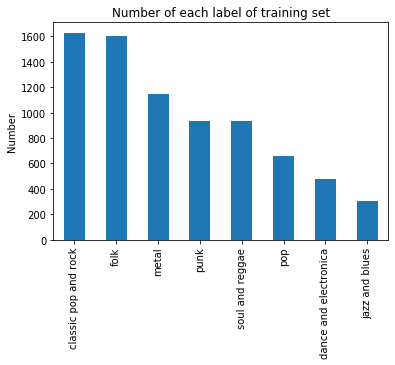

In [3]:
# unbalanced labels
train_labels_1 = pd.read_csv('train_labels.csv')
label_counts = train_labels_1.loc[:,'genre'].value_counts()
print(label_counts)
label_counts.plot(kind='bar')
plt.title("Number of each label of training set")
plt.ylabel("Number")

In [54]:
# 数据分析
# feature与类别的相关性
import scipy as sc
print(sc.stats.pearsonr(train_features_numerics_withoutID.loudness,train_labels.genre))

(-0.0457440099721622, 6.0788611232733496e-05)


In [10]:
# scaling feature colomns
scaler = StandardScaler()
train_features_rangeFix = scaler.fit_transform(np.array(train_features_numerics_withoutID, dtype = float))
valid_features_rangeFix = scaler.fit_transform(np.array(valid_features_numerics_withoutID, dtype = float))
test_features_rangeFix = scaler.fit_transform(np.array(test_features_numerics_withoutID, dtype = float))
print(train_features_rangeFix)
print(valid_features_rangeFix)
print(test_features_rangeFix)

# 包括歌词与数据的所有features
train_features_all = np.hstack((train_features_lyric,train_features_rangeFix))
valid_features_all = np.hstack((valid_features_lyric,valid_features_rangeFix))
test_features_all = np.hstack((test_features_lyric,test_features_rangeFix))
print(train_features_all)

[[ 1.51281735  0.17174441  0.35958741 ...  0.51979765 -1.03440779
  -0.11399671]
 [-0.39800641  0.30261604  0.35958741 ... -0.86553255 -0.80669105
  -0.08538059]
 [ 0.58110649 -1.53125843  0.35958741 ...  0.25526992  1.38028639
   0.06221114]
 ...
 [-0.54180015 -0.79006557  0.35958741 ... -0.82118975 -0.2810968
  -0.07992305]
 [ 1.35541537 -0.7023663   0.35958741 ...  0.22927586 -0.1410315
  -0.06200128]
 [ 0.51646735 -0.1851337   0.35958741 ... -0.03830999 -0.69925486
  -0.0993703 ]]
[[-3.88553305e-01 -1.04323219e+00 -4.66171338e-01 ...  5.51204808e-01
   1.20200281e+00  1.87913862e-01]
 [ 3.02907844e-01 -1.66697201e-03 -2.14438815e+00 ...  5.08764063e-01
   1.11364151e+00  4.57905523e-01]
 [ 1.03498761e+00 -1.93248931e-01  3.72937070e-01 ...  2.63345845e-01
   6.67028214e-01 -2.01748089e-01]
 ...
 [-3.41558507e-01  2.35114901e+00 -2.14438815e+00 ... -8.12434767e-01
   9.23670633e-01  2.53400080e+00]
 [-5.30246164e-01  7.31495183e-01  3.72937070e-01 ... -4.43384814e-01
  -1.02402014e+

In [11]:
# weighted samples
from sklearn.utils.class_weight import compute_sample_weight
training_label_weight = compute_sample_weight("balanced", train_labels_withoutID)
print(training_label_weight)

[0.83967629 0.59946908 0.59946908 ... 0.58916513 0.83967629 0.83967629]


In [12]:
# K-NN implementation
from sklearn.neighbors import KNeighborsClassifier
X_train = train_features_rangeFix
y_train = train_labels.genre
X_test = valid_features_rangeFix
y_test = valid_labels.genre
X_final_test = test_features_rangeFix
#KNNclassifier = KNeighborsClassifier(11, weights='distance')
KNNclassifier = KNeighborsClassifier(11,n_jobs=-1)
#print('KNN corss-val acc on training set:', np.mean(cross_val_score(KNNclassifier, X_train, y_train, cv=5)))
KNNclassifier.fit(X_train, y_train)
y_predict_KNN = KNNclassifier.predict(X_test)
final_predict_KNN = KNNclassifier.predict(X_final_test)
print('KNN acc on training set:', KNNclassifier.score(X_train, y_train))
print('KNN acc on valid set:', KNNclassifier.score(X_test, y_test))

Acc = metrics.accuracy_score(y_test, y_predict_KNN) # Accuracy
print(Acc)
print(metrics.confusion_matrix(y_test, y_predict_KNN))
# High Bias Model


KNN acc on training set: 0.7004428236519927
KNN acc on valid set: 0.48444444444444446
0.48444444444444446
[[44  4  0  2  0  6  2  0]
 [ 2 17  0  1  0 35 19  0]
 [ 0  2 22  0  0  9 10  1]
 [ 4  0  3  7  0 22  8  0]
 [10  4  4  0  7  7  8  5]
 [ 0  4  1  1  0 36 22  0]
 [ 8  1  1  2  0 12 31  0]
 [ 0  2  8  0  1  0  1 54]]


In [13]:
# bagginng KNN
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
X_train = train_features_rangeFix
X_test = valid_features_rangeFix
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_rangeFix
clf_KNN_bagging = BaggingClassifier(KNeighborsClassifier(11)
                                    ,n_estimators=10, random_state=0, n_jobs=-1)
clf_KNN_bagging.fit(X_train,y_train)
y_predict_KNN_bagging = clf_KNN_bagging.predict(X_test)  
final_predict_KNN_bagging = clf_KNN_bagging.predict(X_final_test)
print('KNN bagging acc on training set:', clf_KNN_bagging.score(X_train, y_train))
print('KNN bagging on valid set:', clf_KNN_bagging.score(X_test, y_test))
print(metrics.confusion_matrix(y_test, y_predict_KNN_bagging))

KNN bagging acc on training set: 0.6944516801250326
KNN bagging on valid set: 0.4266666666666667
[[39  5  0  2  0  8  4  0]
 [ 2 10  0  0  0 36 26  0]
 [ 0  1 19  0  0  8 14  2]
 [ 1  2  1  3  0 23 14  0]
 [ 6  5  5  0  5  7 12  5]
 [ 2  2  1  1  0 30 28  0]
 [ 6  2  1  1  0 12 33  0]
 [ 1  2  9  0  0  0  1 53]]


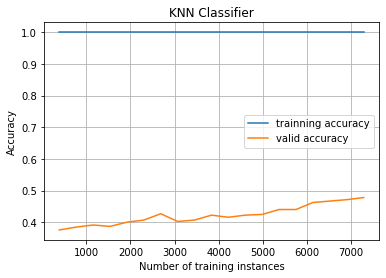

In [20]:
# using different number of instances
total = train_features_rangeFix.shape[0]
instance_part = np.arange(0, 1, 0.05)
acc_train_set = []
acc_valid_set = []
for i in range(1,20):
    X_train = train_features_rangeFix[0:int(total*instance_part[i])]
    y_train = train_labels.genre[0:int(total*instance_part[i])]
    X_test = valid_features_rangeFix
    y_test = valid_labels.genre
    KNNclassifier1 = KNeighborsClassifier(11, weights='distance') 
    KNNclassifier1.fit(X_train,y_train)
    acc_train_set.append(KNNclassifier1.score(X_train, y_train))
    acc_valid_set.append(KNNclassifier1.score(X_test, y_test))
#plot
plt.plot(np.arange(0.05, 1, 0.05)*total,acc_train_set, label = 'trainning accuracy')
plt.plot(np.arange(0.05, 1, 0.05)*total,acc_valid_set, label = 'valid accuracy')
plt.grid(True)
plt.axis('tight') 
plt.legend(loc = 0) 
plt.xlabel('Number of training instances')
plt.ylabel('Accuracy')
plt.title('KNN Classifier')
plt.show()

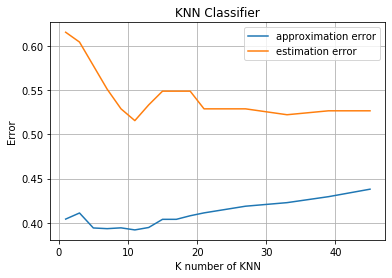

In [35]:
# using different K number 
K_number = [1,3,5,7,9,11,13,15,17,19,21,27,33,39,45]
approximation_error = []
estimation_error = []
index_ls = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
X_train = train_features_rangeFix
y_train = train_labels.genre
X_test = valid_features_rangeFix
y_test = valid_labels.genre
for i in range(len(K_number)):
    KNNclassifier1 = KNeighborsClassifier(K_number[i]) 
    KNNclassifier1.fit(X_train,y_train)
    approximation_error.append(1-np.mean(cross_val_score(KNNclassifier1, X_train, y_train, cv=5)))
    estimation_error.append(1-KNNclassifier1.score(X_test, y_test))
#plot
plt.plot(K_number,approximation_error, label = 'approximation error')
plt.plot(K_number,estimation_error, label = 'estimation error')
plt.grid(True)
plt.axis('tight') 
plt.legend(loc = 0) 
plt.xlabel('K number of KNN')
plt.ylabel('Error')
plt.title('KNN Classifier')
plt.show()

In [18]:
# Choose K number with GridSearch
X_train = train_features_rangeFix
y_train = train_labels.genre
parameter = {'n_neighbors':[1,3,5,7,9,11,13,15,17,19,21,23,25]}
knn = KNeighborsClassifier()

clf = GridSearchCV(knn,parameter,cv=5)
clf.fit(X_train,y_train)

print('评估最合适的K值为：',clf.best_params_,"其准确率为：%.2f"%clf.best_score_)


评估最合适的K值为： {'n_neighbors': 11} 其准确率为：0.61


In [5]:
# 0-R baseline
zeroR = DummyClassifier(strategy='most_frequent')
zeroR.fit(train_features_numerics_withoutID, train_labels_withoutID.values.ravel())
print('0R acc on training set:', zeroR.score(X_train, y_train))
print('0R acc on valid set:', zeroR.score(valid_features_numerics_withoutID, valid_labels_withoutID))

0R acc on training set: 0.21216462620474083
0R acc on valid set: 0.12222222222222222


In [17]:
# Naive Bayes with lyric feature

X_train = train_features_lyric
X_test = valid_features_lyric
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_lyric
mnb = MultinomialNB()   # 使用默认配置初始化朴素贝叶斯
#print('NB corss-val acc on training set:', np.mean(cross_val_score(mnb, X_train, y_train, cv=5)))
mnb.fit(X_train,y_train, sample_weight = training_label_weight)    # 利用训练数据对模型参数进行估计
y_predict_NB = mnb.predict(X_test)     # 对参数进行预测
final_predict_NB = mnb.predict(X_final_test)
print('NB with lyric acc on training set:', mnb.score(X_train, y_train))
print('NB with lyric acc on valid set:', mnb.score(X_test, y_test))
print(metrics.confusion_matrix(y_test, y_predict_NB))



NB with lyric acc on training set: 0.6064079187288356
NB with lyric acc on valid set: 0.5733333333333334
[[41  0  0  5  2  3  6  1]
 [ 0 74  0  0  0  0  0  0]
 [ 1  0 31  1  4  1  2  4]
 [ 2  3  1 10  1  5 18  4]
 [ 9  0  1  6  6 12  9  2]
 [ 1  0  0  5  0 39 13  6]
 [14  0  0 16  4  6 15  0]
 [ 5  2  2  0  8  2  5 42]]


In [70]:
genres = ['Soul..','Pop','Punk','Jazz..','Dance..','Folk','Classic..','Metal']
a = metrics.confusion_matrix(y_test, y_predict_SVC)
pd.DataFrame(a, index = genres, columns = genres)

,Soul..,Pop,Punk,Jazz..,Dance..,Folk,Classic..,Metal
Soul..,37,0,0,3,15,1,2,0
Pop,0,73,0,0,0,0,1,0
Punk,0,3,33,0,0,3,4,1
Jazz..,3,0,2,16,3,13,6,1
Dance..,5,3,7,2,15,6,4,3
Folk,1,0,3,1,0,37,22,0
Classic..,2,0,1,13,0,7,32,0
Metal,0,1,7,0,2,0,0,56


In [60]:
total = train_features_lyric.shape[0]
instance_part = np.arange(0, 1, 0.05)
acc_train_set = []
acc_valid_set = []
for i in range(1,20):
    X_train = train_features_lyric.head(int(total*instance_part[i]))
    y_train = train_labels.genre.head(int(total*instance_part[i]))
    X_test = valid_features_lyric
    y_test = valid_labels.genre
    mnb1 = MultinomialNB() 
    mnb1.fit(X_train,y_train)
    acc_train_set.append(mnb1.score(X_train, y_train))
    acc_valid_set.append(mnb1.score(X_test, y_test))
print(acc_train_set)
print(acc_valid_set)

[0.7023498694516971, 0.7040417209908736, 0.7098175499565595, 0.6912052117263844, 0.6831683168316832, 0.6765089014329136, 0.676218831410495, 0.6506024096385542, 0.6486251808972504, 0.638707996874186, 0.6326385599242066, 0.6267911419887103, 0.6232464929859719, 0.6159285448455527, 0.6154914901007295, 0.6092478020188864, 0.6055776892430279, 0.6024602026049204, 0.5984370715656704]
[0.42, 0.5044444444444445, 0.5311111111111111, 0.56, 0.5733333333333334, 0.5866666666666667, 0.5822222222222222, 0.5844444444444444, 0.5822222222222222, 0.5844444444444444, 0.5911111111111111, 0.5955555555555555, 0.5933333333333334, 0.5911111111111111, 0.5911111111111111, 0.5888888888888889, 0.5822222222222222, 0.5755555555555556, 0.58]


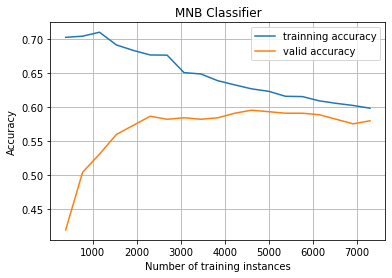

In [69]:
plt.plot(np.arange(0.05, 1, 0.05)*total,acc_train_set, label = 'trainning accuracy')
plt.plot(np.arange(0.05, 1, 0.05)*total,acc_valid_set, label = 'valid accuracy')
plt.grid(True)
plt.axis('tight') 
plt.legend(loc = 0) 
plt.xlabel('Number of training instances')
plt.ylabel('Accuracy')
plt.title('MNB Classifier')
plt.show()

In [203]:
# Decision Tree
X_train = train_features_all
X_test = valid_features_all
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_all
cls = DecisionTreeClassifier(random_state=0, class_weight='balanced')
#print('Decision Tree corss-val acc on training set:', np.mean(cross_val_score(cls, X_train, y_train, cv=5)))
cls.fit(X_train, y_train)
y_predict_DT = cls.predict(X_test)  
final_predict_DT = cls.predict(X_final_test)
print('Decision Tree acc on training set:', cls.score(X_train, y_train))
print('Decision Tree acc on valid set:', cls.score(X_test, y_test))
print(metrics.confusion_matrix(y_test, y_predict_SVC))

Decision Tree acc on training set: 1.0
Decision Tree acc on valid set: 0.4066666666666667
[[37  0  0  3 15  1  2  0]
 [ 0 73  0  0  0  0  1  0]
 [ 0  3 33  0  0  3  4  1]
 [ 3  0  2 16  3 13  6  1]
 [ 5  3  7  2 15  6  4  3]
 [ 1  0  3  1  0 37 22  0]
 [ 2  0  1 13  0  7 32  0]
 [ 0  1  7  0  2  0  0 56]]


In [64]:
# bagginng DT
from sklearn.ensemble import BaggingClassifier
X_train = train_features_all
X_test = valid_features_all
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_all
clf_DT_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=0,class_weight='balanced')
                                    ,n_estimators=100, random_state=0, n_jobs=-1)
clf_DT_bagging.fit(X_train,y_train,  sample_weight = training_label_weight)
y_predict_DT_bagging = clf_DT_bagging.predict(X_test)  
final_predict_DT_bagging = clf_DT_bagging.predict(X_final_test)
print('DT with bagging acc on training set:', clf_DT_bagging.score(X_train, y_train))
print('DT with bagging on valid set:', clf_DT_bagging.score(X_test, y_test))
print(metrics.confusion_matrix(y_test, y_predict_DT_bagging))

DT with bagging acc on training set: 1.0
DT with bagging on valid set: 0.6311111111111111
[[42  0  0  0  0 10  6  0]
 [ 0 70  4  0  0  0  0  0]
 [ 0  2 33  0  0  5  4  0]
 [ 3  0  1 10  1 19  9  1]
 [ 8  1  3  0 10  8 10  5]
 [ 1  0  1  1  0 38 22  1]
 [ 1  0  4  2  0 21 27  0]
 [ 0  0 11  0  0  1  0 54]]


In [21]:
# Multi-layer Perceptron
X_train = train_features_rangeFix
X_test = valid_features_rangeFix
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_rangeFix
clf = MLPClassifier(max_iter = 500, hidden_layer_sizes=(256,256), activation='relu', random_state=101)
#clf = MLPClassifier(max_iter = 500, activation='tanh', hidden_layer_sizes=(256,128,64), solver='adam',
#                    alpha=0.001, random_state=101)
#print('corss-val acc on training set:', np.mean(cross_val_score(clf, X, y, cv=5)))
clf.fit(X_train, y_train)
y_predict_MLP = clf.predict(X_test)  
final_predict_MLP = clf.predict(X_final_test)
print(clf)
#print(clf.coefs_)
print('MLP acc on training set:', clf.score(X_train, y_train))
print('MLP acc on valid set:', clf.score(X_test, y_test))


Acc = metrics.accuracy_score(y_test, y_predict_MLP) # Accuracy
print(Acc)
print(metrics.confusion_matrix(y_test, y_predict_MLP))


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(256, 256), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=101, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
MLP acc on training set: 1.0
MLP acc on valid set: 0.4622222222222222
0.4622222222222222
[[34  1  3  0 13  5  2  0]
 [ 4 19  1  1  0 26 22  1]
 [ 1  2 18  1  0  6 16  0]
 [ 1  1  2 11  2 22  4  1]
 [ 2  4  6  1 17  4  7  4]
 [ 0  3  1  0  0 45 15  0]
 [ 6  2  4  2  4 14 23  0]
 [ 0  1 22  0  0  2  0 41]]


In [31]:
# bagginng MLP
from sklearn.ensemble import BaggingClassifier
X_train = train_features_rangeFix
X_test = valid_features_rangeFix
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_rangeFix
clf_MLP_bagging = BaggingClassifier(base_estimator=MLPClassifier(max_iter = 500, hidden_layer_sizes=(256,256), activation='relu')
                                    ,n_estimators=10, random_state=0, n_jobs=-1)
clf_MLP_bagging.fit(X_train,y_train)
y_predict_MLP_bagging = clf_MLP_bagging.predict(X_test)  
final_predict_MLP_bagging = clf_MLP_bagging.predict(X_final_test)
print('MLP acc on training set:', clf_MLP_bagging.score(X_train, y_train))
print('MLP acc on valid set:', clf_MLP_bagging.score(X_test, y_test))
print(metrics.confusion_matrix(y_test, y_predict_MLP_bagging))

MLP acc on training set: 0.9859338369367022
MLP acc on valid set: 0.49333333333333335
[[38  3  2  0  5  6  4  0]
 [ 2 22  1  0  0 26 22  1]
 [ 1  2 20  1  0  4 16  0]
 [ 2  2  2 10  0 24  3  1]
 [ 6  2  7  0 14  9  3  4]
 [ 0  4  2  0  0 45 13  0]
 [ 7  0  0  2  2 15 29  0]
 [ 0  2 20  0  0  0  0 44]]


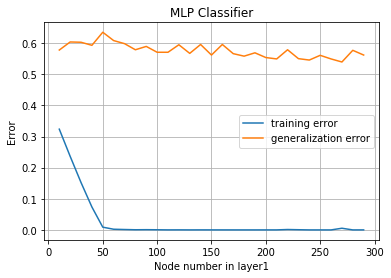

In [18]:
# find best Node number in layer 1
num = np.arange(10, 300, 10)
X_train = train_features_rangeFix
y_train = train_labels.genre
X_test = pd.DataFrame(valid_features_rangeFix)
y_test = pd.DataFrame(valid_labels.genre)
test_data = pd.merge(X_test,y_test, left_index=True, right_index=True)
approximation_error = []
estimation_error =[]
for i in range(len(num)):
    a = []
    b = []
    for j in range(10):
        clf_test = MLPClassifier(max_iter = 1000, hidden_layer_sizes=(num[i]))
        clf_test.fit(X_train, y_train)
        b.append(1-clf_test.score(X_train, y_train))
        test_part = pd.DataFrame(test_data).sample(frac=0.25)
        X_test_part = test_part.drop(columns = ['genre'])
        y_test_part = test_part['genre']
        a.append(1-clf_test.score(X_test_part, y_test_part))
    approximation_error.append(np.mean(b))
    estimation_error.append(np.mean(a))
#plot
plt.plot(num,approximation_error, label = 'training error')
plt.plot(num,estimation_error, label = 'generalization error')
plt.grid(True)
plt.axis('tight') 
plt.legend(loc = 0) 
plt.xlabel('Node number in layer1')
plt.ylabel('Error')
plt.title('MLP Classifier')
plt.show()

In [12]:
X_test = valid_features_rangeFix
y_test = valid_labels.genre
# X_test_part = pd.DataFrame(X_test).sample(frac=0.25)
# print(X_test_part)
X_test=pd.DataFrame(X_test)
y_test=pd.DataFrame(y_test)
result = pd.merge(X_test,y_test, left_index=True, right_index=True)
print(result)

            0         1         2         3         4         5         6  \
0   -0.388553 -1.043232 -0.466171  0.383335  0.658119  4.796910 -1.113637   
1    0.302908 -0.001667 -2.144388 -1.527274  0.658119 -0.898037  0.521116   
2    1.034988 -0.193249  0.372937 -0.435497  0.658119  0.033439  1.012970   
3   -1.740775  0.578747  0.372937  0.929223  0.658119  0.368899 -1.304542   
4   -0.460108  0.629469  0.372937  1.202167 -1.519481 -0.880842 -0.356883   
..        ...       ...       ...       ...       ...       ...       ...   
445  0.786789  0.443236  0.372937 -0.162553  0.658119  0.365110  0.941028   
446  1.365132  1.423876 -2.144388  1.202167 -1.519481  0.855330  1.369355   
447 -0.341559  2.351149 -2.144388 -1.527274  0.658119 -0.978478 -0.506995   
448 -0.530246  0.731495  0.372937 -1.527274  0.658119  0.661515 -0.546681   
449  1.441646 -0.785726 -2.144388  0.110391 -1.519481 -2.026535  1.575678   

            7         8         9  ...       145       146       147  \
0  

In [20]:
# Choose parameters with GridSearch
X_train = train_features_rangeFix
y_train = train_labels.genre
mlp_gs = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(256,128),(256,128,64),(256,64,16),(256,128,128),(256,128,32),(256,256,256)],
#     'activation': ['tanh', 'relu','logistic'],
   # 'solver': ['sgd', 'adam'],
   # 'alpha': [0.0001, 0.05],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'hidden_layer_sizes': (256, 256, 256)}


In [25]:
# RBF SVM Classifier
X_train = train_features_all
X_test = valid_features_all
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_all
#SVC_clf = SVC(kernel='linear')
SVC_clf = SVC(random_state = 0)
SVC_clf.fit(X_train, y_train, sample_weight = training_label_weight)
y_predict_SVC = SVC_clf.predict(X_test)
final_predict_SVC = SVC_clf.predict(X_final_test)
print('SVC acc on training set:', SVC_clf.score(X_train, y_train))
print('SVC acc on valid set:', SVC_clf.score(X_test, y_test))

Acc = metrics.accuracy_score(y_test, y_predict_SVC) # Accuracy
print(Acc)
print(metrics.confusion_matrix(y_test, y_predict_SVC))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC acc on training set: 0.6120083355040375
SVC acc on valid set: 0.6644444444444444
0.6644444444444444
[[37  0  0  3 15  1  2  0]
 [ 0 73  0  0  0  0  1  0]
 [ 0  3 33  0  0  3  4  1]
 [ 3  0  2 16  3 13  6  1]
 [ 5  3  7  2 15  6  4  3]
 [ 1  0  3  1  0 37 22  0]
 [ 2  0  1 13  0  7 32  0]
 [ 0  1  7  0  2  0  0 56]]


In [26]:
# bagginng SVC
from sklearn.ensemble import BaggingClassifier
X_train = train_features_rangeFix
X_test = valid_features_rangeFix
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_rangeFix
clf_SVC_bagging = BaggingClassifier(base_estimator=SVC()
                                    ,n_estimators=20, random_state=0, n_jobs=-1)
clf_SVC_bagging.fit(X_train,y_train, sample_weight = training_label_weight)
y_predict_SVC_bagging = clf_SVC_bagging.predict(X_test)  
final_predict_SVC_bagging = clf_SVC_bagging.predict(X_final_test)
print('SVC bagging acc on training set:', clf_SVC_bagging.score(X_train, y_train))
print('SVC bagging acc on valid set:', clf_SVC_bagging.score(X_test, y_test))
print(metrics.confusion_matrix(y_test, y_predict_SVC_bagging))

SVC bagging acc on training set: 0.7789789007554051
SVC bagging acc on valid set: 0.5622222222222222
[[41  3  1  0  6  4  3  0]
 [ 2 38  1  2  0 14 17  0]
 [ 1  1 27  1  2  5  7  0]
 [ 2  2  2 16  0 19  2  1]
 [ 3  4  4  0 18 10  2  4]
 [ 0  5  1  0  1 40 16  1]
 [ 8  1  3  2  2 10 29  0]
 [ 0  1 17  0  4  0  0 44]]


In [29]:
# Random Forest Classifier
import time
X_train = train_features_all
X_test = valid_features_all
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_all
start = time.clock()
RF_clf = RandomForestClassifier(n_estimators=200, random_state=101,class_weight='balanced')
RF_clf.fit(X_train, y_train, sample_weight = training_label_weight)
elapsed = (time.clock() - start)
y_predict_RF = RF_clf.predict(X_test)
final_predict_RF = RF_clf.predict(X_final_test)
print('RF acc on training set:', RF_clf.score(X_train, y_train))
print('RF acc on valid set:', RF_clf.score(X_test, y_test))

Acc = metrics.accuracy_score(y_test, y_predict_RF) # Accuracy
print(Acc)
print('Training time:',elapsed,'s')
print(metrics.confusion_matrix(y_test, y_predict_RF))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


RF acc on training set: 1.0
RF acc on valid set: 0.6266666666666667
0.6266666666666667
Training time: 24.032588900000064 s
[[40  0  0  0  1 11  6  0]
 [ 0 73  0  0  0  1  0  0]
 [ 0  1 29  0  0  4  4  6]
 [ 1  0  1  0  0 32  9  1]
 [ 6  1  5  0  7  9 12  5]
 [ 0  0  1  0  0 39 24  0]
 [ 2  0  0  0  0 23 29  1]
 [ 0  0  0  0  0  0  1 65]]


In [30]:
# AdaBoost Classifier
X_train = train_features_all
X_test = valid_features_all
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_all
AB_clf = AdaBoostClassifier(n_estimators=100, random_state=101)
AB_clf.fit(X_train, y_train, sample_weight = training_label_weight)
y_predict_AB = AB_clf.predict(X_test)
final_predict_AB = AB_clf.predict(X_final_test)
print('AB acc on training set:', AB_clf.score(X_train, y_train))
print('AB acc on valid set:', AB_clf.score(X_test, y_test))

Acc = metrics.accuracy_score(y_test, y_predict_AB) # Accuracy
print(Acc)
print(metrics.confusion_matrix(y_test, y_predict_AB))

AB acc on training set: 0.4399583224798124
AB acc on valid set: 0.4888888888888889
0.4888888888888889
[[16  1  2 12 22  0  4  1]
 [ 1 63  4  5  0  1  0  0]
 [ 1  5 10  2  0  3  7 16]
 [ 3  4  1 20  1  9  3  3]
 [ 4  2  1  3 19  1  4 11]
 [10  2  1  7  3 24 16  1]
 [ 7  0  5 17  4 13  8  1]
 [ 0  0  2  0  4  0  0 60]]


In [38]:
### GBDT(Gradient Boosting Decision Tree) Classifier    
from sklearn.ensemble import GradientBoostingClassifier
import time
X_train = train_features_all
X_test = valid_features_all
y_train = train_labels.genre
y_test = valid_labels.genre
X_final_test = test_features_all
start = time.clock()
GBDT_clf = GradientBoostingClassifier(n_estimators=200, random_state=101)
GBDT_clf.fit(X_train, y_train, sample_weight = training_label_weight)
elapsed = (time.clock() - start)
y_predict_GBDT = GBDT_clf.predict(X_test)
final_predict_GBDT = GBDT_clf.predict(X_final_test)
print('GBDT acc on training set:', GBDT_clf.score(X_train, y_train))
print('GBDT acc on valid set:', GBDT_clf.score(X_test, y_test))

Acc = metrics.accuracy_score(y_test, y_predict_GBDT) # Accuracy
print(Acc)
print('Training time:',elapsed,'s')
print(metrics.confusion_matrix(y_test, y_predict_GBDT))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


GBDT acc on training set: 0.92771555092472
GBDT acc on valid set: 0.68
0.68
Training time: 1475.9871341000003 s
[[42  0  0  0  9  0  7  0]
 [ 0 72  1  1  0  0  0  0]
 [ 0  1 35  2  0  4  2  0]
 [ 2  3  2 17  2 12  5  1]
 [ 2  0  6  3 19  7  4  4]
 [ 1  0  0  0  1 45 17  0]
 [ 9  0  4  2  3 12 25  0]
 [ 0  0 14  0  0  0  1 51]]


In [98]:
# stacking
# with voting
from collections import Counter
# X_train = np.vstack(([y_predict_MLP_bagging], [y_predict_NB], [y_predict_KNN], [y_predict_SVC], 
#                      [y_predict_RF], [y_predict_GBDT], [y_predict_DT_bagging])).T
# X_train = np.vstack(([y_predict_SVC], [y_predict_RF], [y_predict_GBDT])).T  #0.625
X_train = np.vstack(([y_predict_SVC], [y_predict_DT_bagging], [y_predict_NB])).T #0.648

#print(X_train.shape)
y_train = valid_labels.genre
np.set_printoptions(threshold=np.inf)  
#print(X_train) 

y_pred = []
for i in range(len(X_train)):
    #y_pred.append(np.argmax(np.bincount(X_train[i])))
    if np.bincount(X_train[i]).max() > 1:
        y_pred.append(np.argmax(np.bincount(X_train[i])))
    # 如果都一样的话，没有多数，选准确率最高的NB
    else:
        y_pred.append(X_train[i][0])
    #print(np.argmax(np.bincount(X_train[i])))
print(y_pred)

#print(y_train)
Acc = metrics.accuracy_score(y_train, y_pred) # Accuracy
print('Acc: ',Acc)
y_test = valid_labels.genre
print(metrics.confusion_matrix(y_test, y_pred))


[0, 6, 7, 5, 4, 6, 6, 1, 1, 0, 5, 7, 1, 1, 7, 4, 6, 1, 5, 6, 1, 6, 1, 6, 7, 1, 6, 7, 0, 1, 5, 1, 1, 3, 1, 5, 0, 5, 1, 0, 0, 5, 0, 5, 3, 1, 6, 2, 2, 5, 6, 2, 5, 3, 3, 5, 6, 1, 1, 2, 6, 4, 2, 2, 5, 2, 7, 1, 1, 6, 0, 6, 5, 1, 6, 0, 3, 3, 7, 7, 6, 5, 7, 7, 2, 7, 0, 6, 7, 7, 2, 4, 7, 6, 0, 1, 0, 2, 5, 5, 1, 2, 1, 3, 7, 6, 2, 1, 5, 5, 7, 4, 7, 0, 2, 3, 7, 5, 7, 6, 6, 0, 5, 0, 6, 4, 1, 4, 4, 2, 0, 2, 1, 1, 2, 6, 7, 2, 7, 3, 6, 1, 2, 1, 6, 5, 0, 1, 6, 6, 5, 3, 5, 6, 5, 0, 6, 7, 6, 1, 5, 7, 7, 7, 6, 3, 2, 2, 6, 5, 3, 0, 2, 2, 3, 1, 2, 3, 6, 6, 6, 0, 7, 4, 7, 3, 5, 0, 1, 5, 7, 5, 7, 0, 3, 1, 2, 6, 3, 4, 1, 0, 6, 2, 0, 6, 7, 2, 1, 5, 6, 6, 0, 1, 5, 0, 1, 5, 2, 1, 5, 1, 6, 3, 0, 2, 1, 1, 6, 7, 6, 7, 1, 5, 6, 0, 1, 4, 1, 3, 1, 5, 0, 0, 0, 0, 0, 7, 5, 5, 0, 5, 5, 5, 5, 2, 0, 2, 6, 6, 6, 1, 5, 0, 2, 7, 1, 6, 6, 0, 7, 5, 2, 5, 3, 5, 0, 2, 7, 2, 7, 5, 7, 3, 3, 7, 4, 5, 2, 1, 5, 6, 4, 5, 6, 7, 4, 7, 7, 1, 0, 4, 7, 0, 5, 1, 1, 1, 2, 2, 5, 5, 5, 6, 4, 6, 2, 4, 5, 1, 1, 5, 1, 0, 2, 1, 1, 0, 1, 7, 0, 5, 1, 

In [73]:
# stacking
# with Meta Classification
from sklearn.linear_model import Perceptron
X_train = np.vstack(([y_predict_SVC], [y_predict_RF], [y_predict_GBDT])).T
X=pd.DataFrame(X_train)
X_train = X.replace([0,1,2,3,4,5,6,7], ['soul and reggae','pop','punk','jazz and blues','dance and electronica','folk','classic pop and rock','metal'])
X_train = pd.get_dummies(X_train)
y_train = valid_labels.genre.replace([0,1,2,3,4,5,6,7], ['soul and reggae','pop','punk','jazz and blues','dance and electronica','folk','classic pop and rock','metal'])
X_final_test = np.vstack(([final_predict_SVC], [final_predict_RF], [final_predict_GBDT])).T
X_final = pd.DataFrame(X_final_test).replace([0,1,2,3,4,5,6,7], ['soul and reggae','pop','punk','jazz and blues','dance and electronica','folk','classic pop and rock','metal'])
X_final_test = pd.get_dummies(X_final)
meta_clf = Perceptron(random_state=0)
meta_clf.fit(X_train, y_train)        
final_predict_stacking_NB = meta_clf.predict(X_final_test)
print('Stacking Meta Classification with NB on training set:', meta_clf.score(X_train, y_train))
#print(final_predict_stacking_NB)

output=pd.DataFrame(final_predict_stacking_NB)
output = output.replace([0,1,2,3,4,5,6,7], ['soul and reggae','pop','punk','jazz and blues','dance and electronica','folk','classic pop and rock','metal'])

Stacking Meta Classification with NB on training set: 0.6733333333333333


In [97]:
# predict for test set
# X_final_test = np.vstack(([final_predict_MLP_bagging], [final_predict_KNN], [final_predict_NB],[final_predict_SVC], 
#                           [final_predict_RF], [final_predict_GBDT], [final_predict_DT_bagging])).T
#X_final_test = np.vstack(([final_predict_SVC], [final_predict_RF], [final_predict_GBDT])).T #0.60
#X_final_test = np.vstack(([final_predict_GBDT])).T #0.625
#X_final_test = np.vstack(([final_predict_SVC], [final_predict_RF], [final_predict_GBDT])).T #0.625
X_final_test = np.vstack(([final_predict_SVC], [final_predict_DT_bagging], [final_predict_NB])).T #0.648

print(X_final_test)
y_final_pred = []
for i in range(len(X_final_test)):
    #y_final_pred.append(np.argmax(np.bincount(X_final_test[i])))
    if np.bincount(X_final_test[i]).max() > 1:
        y_final_pred.append(np.argmax(np.bincount(X_final_test[i])))
    # 如果都一样的话，没有多数，选准确率最高的NB
    else:
        y_final_pred.append(X_final_test[i][0])
print(y_final_pred)


[[6 6 0]
 [7 7 0]
 [4 4 6]
 [6 6 5]
 [0 4 4]
 [3 5 5]
 [7 7 7]
 [1 1 1]
 [5 5 5]
 [6 6 6]
 [5 5 6]
 [6 6 5]
 [0 0 0]
 [6 6 0]
 [5 6 5]
 [4 0 0]
 [6 5 6]
 [5 5 5]
 [7 7 7]
 [6 6 4]
 [0 0 0]
 [6 6 4]
 [1 1 1]
 [6 6 5]
 [5 5 5]
 [6 6 3]
 [4 5 0]
 [0 0 0]
 [5 5 5]
 [0 0 0]
 [5 1 1]
 [6 7 0]
 [5 3 5]
 [7 7 7]
 [4 0 0]
 [1 1 1]
 [5 5 0]
 [2 7 6]
 [4 6 6]
 [3 5 6]
 [3 5 6]
 [6 6 6]
 [2 6 6]
 [0 0 0]
 [6 5 3]
 [6 5 5]
 [2 2 1]
 [5 5 6]
 [6 6 3]
 [5 5 0]
 [0 0 6]
 [7 7 1]
 [0 0 0]
 [5 5 5]
 [2 7 0]
 [5 5 6]
 [0 0 0]
 [0 6 6]
 [1 1 1]
 [1 1 1]
 [2 6 6]
 [7 6 0]
 [6 5 6]
 [7 7 7]
 [1 1 1]
 [0 0 0]
 [0 6 0]
 [7 4 3]
 [2 7 7]
 [6 6 0]
 [3 5 6]
 [5 5 7]
 [6 5 6]
 [1 1 1]
 [3 6 3]
 [6 6 6]
 [6 5 5]
 [0 0 0]
 [1 1 1]
 [4 4 0]
 [5 5 4]
 [2 2 1]
 [1 1 1]
 [6 6 3]
 [6 5 0]
 [6 6 6]
 [5 5 5]
 [2 7 0]
 [5 5 6]
 [4 1 6]
 [0 0 0]
 [0 0 0]
 [5 5 6]
 [6 6 5]
 [5 5 5]
 [1 1 1]
 [0 6 0]
 [1 1 1]
 [6 6 6]
 [0 0 7]
 [2 2 6]
 [6 6 4]
 [5 5 7]
 [0 0 0]
 [1 1 1]
 [6 6 5]
 [6 5 6]
 [0 0 0]
 [2 2 1]
 [5 5 3]
 [5 5 6]
 

In [96]:
def toCSV(X_test, y_predict):
    if len(X_test)!=len(y_predict):
        print('Instance number does not match!')
    else:
        y = pd.DataFrame(np.asarray(y_predict))
        genre_mapping = {
            0: 'soul and reggae',
            1: 'pop',
            2: 'punk',
            3: 'jazz and blues',
            4: 'dance and electronica',
            5: 'folk',
            6: 'classic pop and rock',
            7: 'metal'}
        y = y[0].map(genre_mapping)
        track_ID = X_test.trackID
        y_output = pd.concat([track_ID,y],axis=1, keys=['trackID','genre'])
        y_output.to_csv('test_labels.csv', index=None)

toCSV(test_features, y_final_pred)

In [15]:
X_test = test_features
y_predict = y_final_pred
if len(X_test)!=len(y_predict):
    print('Instance number does not match!')
else:
    y = pd.DataFrame(np.asarray(y_predict))
    genre_mapping = {
            0: 'soul and reggae',
            1: 'pop',
            2: 'punk',
            3: 'jazz and blues',
            4: 'dance and electronica',
            5: 'folk',
            6: 'classic pop and rock',
            7: 'metal'}
    y = y[0].map(genre_mapping)
    track_ID = X_test.trackID
    y_output = pd.concat([track_ID,y],axis=1, keys=['trackID','genre'])
y_output.to_csv('test_labels.csv', index=None)
print(y_output)

     trackID                 genre
0       6732  classic pop and rock
1       5415                 metal
2       7757  classic pop and rock
3       1854  classic pop and rock
4       4942       soul and reggae
..       ...                   ...
423      186                   pop
424     4758                  folk
425     2231  classic pop and rock
426     2925                  folk
427     2075                   pop

[428 rows x 2 columns]


In [73]:
print(metrics.confusion_matrix(valid_labels.genre, y_pred))
print(metrics.accuracy_score(valid_labels.genre, y_pred))
print(metrics.precision_score(valid_labels.genre, y_pred, average = None))
print(metrics.recall_score(valid_labels.genre, y_pred, average = None))

[[48  0  0  0  1  4  4  1]
 [ 0 74  0  0  0  0  0  0]
 [ 0  2 35  0  0  3  2  2]
 [ 3  1  1 12  1 10 14  2]
 [ 6  0  4  3 12 10  6  4]
 [ 0  0  1  0  0 42 20  1]
 [10  0  1 11  2  6 25  0]
 [ 2  0  5  0  2  0  2 55]]
0.6733333333333333
[0.69565217 0.96103896 0.74468085 0.46153846 0.66666667 0.56
 0.34246575 0.84615385]
[0.82758621 1.         0.79545455 0.27272727 0.26666667 0.65625
 0.45454545 0.83333333]


In [57]:
y_train = valid_labels.genre
def getError(y_train, y_pred):
    error = []
    for i in range(len(y_train)):
        if y_train[i] == y_pred[i]:
            error.append(0)
        else:
            error.append(y_train[i]-y_pred[i])
    return error
error_NB = getError(y_train, y_predict_NB)
error_KNN = getError(y_train, y_predict_KNN)
error_DT = getError(y_train, y_predict_DT_bagging)
error_MLP = getError(y_train, y_predict_MLP_bagging)
error_SVC = getError(y_train, y_predict_SVC)
error_RF = getError(y_train, y_predict_RF)
error_GBDT = getError(y_train, y_predict_GBDT)
list1 = np.corrcoef([error_NB,error_KNN, error_MLP, error_DT, error_RF, error_GBDT, error_SVC])
list2 = np.corrcoef([error_NB,error_RF,error_GBDT])
pd.DataFrame(list1)

,0,1,2,3,4,5,6
0,1.000000,0.251269,0.275342,0.347761,0.377442,0.461830,0.347515
1,0.251269,1.000000,0.577067,0.341900,0.300935,0.282059,0.346713
2,0.275342,0.577067,1.000000,0.294950,0.222886,0.406055,0.346283
3,0.347761,0.341900,0.294950,1.000000,0.583345,0.467887,0.498360
4,0.377442,0.300935,0.222886,0.583345,1.000000,0.451203,0.524942
5,0.461830,0.282059,0.406055,0.467887,0.451203,1.000000,0.541575
6,0.347515,0.346713,0.346283,0.498360,0.524942,0.541575,1.000000
